<a href="https://colab.research.google.com/github/CodeJBR/EVA/blob/master/EVA4S5F1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


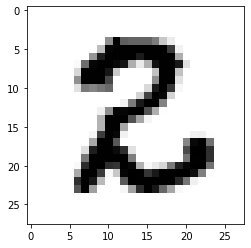

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[1].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

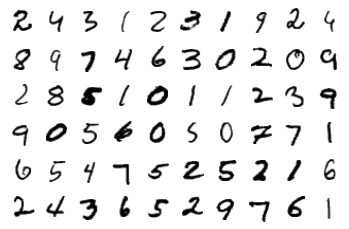

In [0]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# How did we get those mean and std values which we used above?

Let's run a small experiment

In [0]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1305)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3, padding=1) #input -? OUtput? RF
        self.conv2 = nn.Conv2d(10, 10, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(10, 20, 3, padding=1)
        self.conv4 = nn.Conv2d(20, 20, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(20, 20, 3)
        self.conv6 = nn.Conv2d(20, 30, 3)
        self.conv7 = nn.Conv2d(30, 10, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        # x = F.relu(self.conv7(x))
        x = self.conv7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
            Conv2d-2           [-1, 10, 28, 28]             910
         MaxPool2d-3           [-1, 10, 14, 14]               0
            Conv2d-4           [-1, 20, 14, 14]           1,820
            Conv2d-5           [-1, 20, 14, 14]           3,620
         MaxPool2d-6             [-1, 20, 7, 7]               0
            Conv2d-7             [-1, 20, 5, 5]           3,620
            Conv2d-8             [-1, 30, 3, 3]           5,430
            Conv2d-9             [-1, 10, 1, 1]           2,710
Total params: 18,210
Trainable params: 18,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 0.07
Estimated Total Size (MB): 0.28
----------------------------------------

# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments. 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [0]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)



  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0




Loss=2.3043437004089355 Batch_id=0 Accuracy=12.50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=2.3043437004089355 Batch_id=0 Accuracy=12.50:   0%|          | 1/469 [00:00<02:35,  3.01it/s]

Loss=2.300029993057251 Batch_id=1 Accuracy=10.55:   0%|          | 1/469 [00:00<02:35,  3.01it/s] 

Loss=2.3050622940063477 Batch_id=2 Accuracy=10.68:   0%|          | 1/469 [00:00<02:35,  3.01it/s]

Loss=2.300652265548706 Batch_id=3 Accuracy=10.55:   0%|          | 1/469 [00:00<02:35,  3.01it/s] 

Loss=2.3055977821350098 Batch_id=4 Accuracy=10.94:   0%|          | 1/469 [00:00<02:35,  3.01it/s]

Loss=2.3055977821350098 Batch_id=4 Accuracy=10.94:   1%|          | 5/469 [00:00<01:51,  4.16it/s]

Loss=2.3032679557800293 Batch_id=5 Accuracy=10.94:   1%|          | 5/469 [00:00<01:51,  4.16it/s]

Loss=2.304138660430908 Batch_id=6 Accuracy=11.05:   1%|          | 5/469 [00:00<01:51,  4.16it/s] 

Loss=2.3008036613464355 Batch_id=7 Accuracy=11.43:   1%|          | 5/469 [00:00<01:51,  4.16it/s]

Loss=2


Test set: Average loss: 0.1180, Accuracy: 9649/10000 (96.49%)

EPOCH: 1




Loss=0.10242989659309387 Batch_id=0 Accuracy=95.31:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.10242989659309387 Batch_id=0 Accuracy=95.31:   0%|          | 1/469 [00:00<02:10,  3.59it/s]

Loss=0.10340262204408646 Batch_id=1 Accuracy=96.09:   0%|          | 1/469 [00:00<02:10,  3.59it/s]

Loss=0.10681585967540741 Batch_id=2 Accuracy=96.09:   0%|          | 1/469 [00:00<02:10,  3.59it/s]

Loss=0.09728842973709106 Batch_id=3 Accuracy=96.09:   0%|          | 1/469 [00:00<02:10,  3.59it/s]

Loss=0.09728842973709106 Batch_id=3 Accuracy=96.09:   1%|          | 4/469 [00:00<01:35,  4.85it/s]

Loss=0.10790061205625534 Batch_id=4 Accuracy=96.25:   1%|          | 4/469 [00:00<01:35,  4.85it/s]

Loss=0.1562151461839676 Batch_id=5 Accuracy=96.22:   1%|          | 4/469 [00:00<01:35,  4.85it/s] 

Loss=0.12407563626766205 Batch_id=6 Accuracy=96.21:   1%|          | 4/469 [00:00<01:35,  4.85it/s]

Loss=0.07932666689157486 Batch_id=7 Accuracy=96.19:   1%|          | 4/469 [00:00<01:35,  4.85it/


Test set: Average loss: 0.0613, Accuracy: 9799/10000 (97.99%)

EPOCH: 2




Loss=0.09869049489498138 Batch_id=0 Accuracy=96.88:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.09869049489498138 Batch_id=0 Accuracy=96.88:   0%|          | 1/469 [00:00<02:24,  3.23it/s]

Loss=0.06580711901187897 Batch_id=1 Accuracy=97.27:   0%|          | 1/469 [00:00<02:24,  3.23it/s]

Loss=0.022474363446235657 Batch_id=2 Accuracy=97.92:   0%|          | 1/469 [00:00<02:24,  3.23it/s]

Loss=0.02529679611325264 Batch_id=3 Accuracy=98.05:   0%|          | 1/469 [00:00<02:24,  3.23it/s] 

Loss=0.05184060335159302 Batch_id=4 Accuracy=98.12:   0%|          | 1/469 [00:00<02:24,  3.23it/s]

Loss=0.05184060335159302 Batch_id=4 Accuracy=98.12:   1%|          | 5/469 [00:00<01:44,  4.43it/s]

Loss=0.047266457229852676 Batch_id=5 Accuracy=98.18:   1%|          | 5/469 [00:00<01:44,  4.43it/s]

Loss=0.030762597918510437 Batch_id=6 Accuracy=98.33:   1%|          | 5/469 [00:00<01:44,  4.43it/s]

Loss=0.0279071107506752 Batch_id=7 Accuracy=98.44:   1%|          | 5/469 [00:00<01:44,  4.43


Test set: Average loss: 0.0431, Accuracy: 9867/10000 (98.67%)

EPOCH: 3




Loss=0.06524864584207535 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.06524864584207535 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<01:58,  3.94it/s]

Loss=0.08673625439405441 Batch_id=1 Accuracy=98.44:   0%|          | 1/469 [00:00<01:58,  3.94it/s]

Loss=0.019057169556617737 Batch_id=2 Accuracy=98.96:   0%|          | 1/469 [00:00<01:58,  3.94it/s]

Loss=0.019057169556617737 Batch_id=2 Accuracy=98.96:   1%|          | 3/469 [00:00<01:31,  5.09it/s]

Loss=0.12372332066297531 Batch_id=3 Accuracy=98.44:   1%|          | 3/469 [00:00<01:31,  5.09it/s] 

Loss=0.020744601264595985 Batch_id=4 Accuracy=98.59:   1%|          | 3/469 [00:00<01:31,  5.09it/s]

Loss=0.026437994092702866 Batch_id=5 Accuracy=98.44:   1%|          | 3/469 [00:00<01:31,  5.09it/s]

Loss=0.011176757514476776 Batch_id=6 Accuracy=98.66:   1%|          | 3/469 [00:00<01:31,  5.09it/s]

Loss=0.011176757514476776 Batch_id=6 Accuracy=98.66:   1%|▏         | 7/469 [00:00<01:07,  


Test set: Average loss: 0.0497, Accuracy: 9831/10000 (98.31%)

EPOCH: 4




Loss=0.05201168730854988 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.05201168730854988 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:31,  3.09it/s]

Loss=0.10011011362075806 Batch_id=1 Accuracy=96.88:   0%|          | 1/469 [00:00<02:31,  3.09it/s]

Loss=0.04667012393474579 Batch_id=2 Accuracy=97.14:   0%|          | 1/469 [00:00<02:31,  3.09it/s]

Loss=0.02732042223215103 Batch_id=3 Accuracy=97.66:   0%|          | 1/469 [00:00<02:31,  3.09it/s]

Loss=0.04009757936000824 Batch_id=4 Accuracy=97.97:   0%|          | 1/469 [00:00<02:31,  3.09it/s]

Loss=0.04009757936000824 Batch_id=4 Accuracy=97.97:   1%|          | 5/469 [00:00<01:49,  4.25it/s]

Loss=0.089753657579422 Batch_id=5 Accuracy=97.92:   1%|          | 5/469 [00:00<01:49,  4.25it/s]  

Loss=0.01735428348183632 Batch_id=6 Accuracy=98.21:   1%|          | 5/469 [00:00<01:49,  4.25it/s]

Loss=0.08280827105045319 Batch_id=7 Accuracy=98.14:   1%|          | 5/469 [00:00<01:49,  4.25it/


Test set: Average loss: 0.0396, Accuracy: 9869/10000 (98.69%)

EPOCH: 5




Loss=0.1231631338596344 Batch_id=0 Accuracy=96.88:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.1231631338596344 Batch_id=0 Accuracy=96.88:   0%|          | 1/469 [00:00<02:19,  3.34it/s]

Loss=0.0104701928794384 Batch_id=1 Accuracy=98.44:   0%|          | 1/469 [00:00<02:19,  3.34it/s]

Loss=0.01874615252017975 Batch_id=2 Accuracy=98.70:   0%|          | 1/469 [00:00<02:19,  3.34it/s]

Loss=0.016694970428943634 Batch_id=3 Accuracy=98.83:   0%|          | 1/469 [00:00<02:19,  3.34it/s]

Loss=0.02701329067349434 Batch_id=4 Accuracy=98.91:   0%|          | 1/469 [00:00<02:19,  3.34it/s] 

Loss=0.02701329067349434 Batch_id=4 Accuracy=98.91:   1%|          | 5/469 [00:00<01:40,  4.61it/s]

Loss=0.01609598845243454 Batch_id=5 Accuracy=99.09:   1%|          | 5/469 [00:00<01:40,  4.61it/s]

Loss=0.006055746227502823 Batch_id=6 Accuracy=99.22:   1%|          | 5/469 [00:00<01:40,  4.61it/s]

Loss=0.03832196071743965 Batch_id=7 Accuracy=99.12:   1%|          | 5/469 [00:00<01:40,  4.61it/


Test set: Average loss: 0.0346, Accuracy: 9889/10000 (98.89%)

EPOCH: 6




Loss=0.015964943915605545 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.015964943915605545 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:30,  3.10it/s]

Loss=0.0583382211625576 Batch_id=1 Accuracy=98.44:   0%|          | 1/469 [00:00<02:30,  3.10it/s]  

Loss=0.0045773908495903015 Batch_id=2 Accuracy=98.96:   0%|          | 1/469 [00:00<02:30,  3.10it/s]

Loss=0.008469529449939728 Batch_id=3 Accuracy=99.22:   0%|          | 1/469 [00:00<02:30,  3.10it/s] 

Loss=0.03561292588710785 Batch_id=4 Accuracy=99.06:   0%|          | 1/469 [00:00<02:30,  3.10it/s] 

Loss=0.03561292588710785 Batch_id=4 Accuracy=99.06:   1%|          | 5/469 [00:00<01:48,  4.29it/s]

Loss=0.030069010332226753 Batch_id=5 Accuracy=99.09:   1%|          | 5/469 [00:00<01:48,  4.29it/s]

Loss=0.036863699555397034 Batch_id=6 Accuracy=99.11:   1%|          | 5/469 [00:00<01:48,  4.29it/s]

Loss=0.0063446201384067535 Batch_id=7 Accuracy=99.22:   1%|          | 5/469 [00:00<01:


Test set: Average loss: 0.0326, Accuracy: 9885/10000 (98.85%)

EPOCH: 7




Loss=0.005910910665988922 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.005910910665988922 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<02:35,  3.02it/s]

Loss=0.028239041566848755 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<02:35,  3.02it/s] 

Loss=0.042685139924287796 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<02:35,  3.02it/s]

Loss=0.04892556369304657 Batch_id=3 Accuracy=99.02:   0%|          | 1/469 [00:00<02:35,  3.02it/s] 

Loss=0.001982562243938446 Batch_id=4 Accuracy=99.22:   0%|          | 1/469 [00:00<02:35,  3.02it/s]

Loss=0.001982562243938446 Batch_id=4 Accuracy=99.22:   1%|          | 5/469 [00:00<01:51,  4.16it/s]

Loss=0.007504422217607498 Batch_id=5 Accuracy=99.22:   1%|          | 5/469 [00:00<01:51,  4.16it/s]

Loss=0.004353359341621399 Batch_id=6 Accuracy=99.33:   1%|          | 5/469 [00:00<01:51,  4.16it/s]

Loss=0.0340423658490181 Batch_id=7 Accuracy=99.32:   1%|          | 5/469 [00:00<01:5


Test set: Average loss: 0.0357, Accuracy: 9886/10000 (98.86%)

EPOCH: 8




Loss=0.004819165915250778 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.004819165915250778 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<02:09,  3.61it/s]

Loss=0.01651129126548767 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<02:09,  3.61it/s]  

Loss=0.006490819156169891 Batch_id=2 Accuracy=99.48:   0%|          | 1/469 [00:00<02:09,  3.61it/s]

Loss=0.015023387968540192 Batch_id=3 Accuracy=99.41:   0%|          | 1/469 [00:00<02:09,  3.61it/s]

Loss=0.004227455705404282 Batch_id=4 Accuracy=99.53:   0%|          | 1/469 [00:00<02:09,  3.61it/s]

Loss=0.004227455705404282 Batch_id=4 Accuracy=99.53:   1%|          | 5/469 [00:00<01:33,  4.94it/s]

Loss=0.009950850158929825 Batch_id=5 Accuracy=99.48:   1%|          | 5/469 [00:00<01:33,  4.94it/s]

Loss=0.009671904146671295 Batch_id=6 Accuracy=99.44:   1%|          | 5/469 [00:00<01:33,  4.94it/s]

Loss=0.024896759539842606 Batch_id=7 Accuracy=99.41:   1%|          | 5/469 [00:00<01


Test set: Average loss: 0.0315, Accuracy: 9894/10000 (98.94%)

EPOCH: 9




Loss=0.004228513687849045 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.004228513687849045 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<01:57,  3.97it/s]

Loss=0.011670861393213272 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<01:57,  3.97it/s] 

Loss=0.011670861393213272 Batch_id=1 Accuracy=99.61:   0%|          | 2/469 [00:00<01:37,  4.81it/s]

Loss=0.013724811375141144 Batch_id=2 Accuracy=99.48:   0%|          | 2/469 [00:00<01:37,  4.81it/s]

Loss=0.011090964078903198 Batch_id=3 Accuracy=99.41:   0%|          | 2/469 [00:00<01:37,  4.81it/s]

Loss=0.01875929906964302 Batch_id=4 Accuracy=99.38:   0%|          | 2/469 [00:00<01:37,  4.81it/s] 

Loss=0.04816204309463501 Batch_id=5 Accuracy=99.35:   0%|          | 2/469 [00:00<01:37,  4.81it/s]

Loss=0.04816204309463501 Batch_id=5 Accuracy=99.35:   1%|▏         | 6/469 [00:00<01:11,  6.47it/s]

Loss=0.004582658410072327 Batch_id=6 Accuracy=99.44:   1%|▏         | 6/469 [00:00<01:1


Test set: Average loss: 0.0339, Accuracy: 9887/10000 (98.87%)

EPOCH: 10




Loss=0.017122279852628708 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.017122279852628708 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:25,  3.22it/s]

Loss=0.015585631132125854 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<02:25,  3.22it/s]

Loss=0.00821816548705101 Batch_id=2 Accuracy=99.48:   0%|          | 1/469 [00:00<02:25,  3.22it/s] 

Loss=0.013702210038900375 Batch_id=3 Accuracy=99.41:   0%|          | 1/469 [00:00<02:25,  3.22it/s]

Loss=0.0008619576692581177 Batch_id=4 Accuracy=99.53:   0%|          | 1/469 [00:00<02:25,  3.22it/s]

Loss=0.0008619576692581177 Batch_id=4 Accuracy=99.53:   1%|          | 5/469 [00:00<01:45,  4.40it/s]

Loss=0.015365850180387497 Batch_id=5 Accuracy=99.61:   1%|          | 5/469 [00:00<01:45,  4.40it/s] 

Loss=0.0012247487902641296 Batch_id=6 Accuracy=99.67:   1%|          | 5/469 [00:00<01:45,  4.40it/s]

Loss=0.017381243407726288 Batch_id=7 Accuracy=99.61:   1%|          | 5/469 [00:00<0


Test set: Average loss: 0.0355, Accuracy: 9886/10000 (98.86%)

EPOCH: 11




Loss=0.011793747544288635 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.011793747544288635 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<02:04,  3.75it/s]

Loss=0.000596068799495697 Batch_id=1 Accuracy=100.00:   0%|          | 1/469 [00:00<02:04,  3.75it/s]

Loss=0.007515337318181992 Batch_id=2 Accuracy=100.00:   0%|          | 1/469 [00:00<02:04,  3.75it/s]

Loss=0.007515337318181992 Batch_id=2 Accuracy=100.00:   1%|          | 3/469 [00:00<01:35,  4.86it/s]

Loss=0.015696745365858078 Batch_id=3 Accuracy=99.80:   1%|          | 3/469 [00:00<01:35,  4.86it/s] 

Loss=0.001475602388381958 Batch_id=4 Accuracy=99.84:   1%|          | 3/469 [00:00<01:35,  4.86it/s]

Loss=0.01590210571885109 Batch_id=5 Accuracy=99.74:   1%|          | 3/469 [00:00<01:35,  4.86it/s] 

Loss=0.0506984144449234 Batch_id=6 Accuracy=99.33:   1%|          | 3/469 [00:00<01:35,  4.86it/s] 

Loss=0.0506984144449234 Batch_id=6 Accuracy=99.33:   1%|▏         | 7/469 [00:00<01


Test set: Average loss: 0.0294, Accuracy: 9899/10000 (98.99%)

EPOCH: 12




Loss=0.03694119304418564 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.03694119304418564 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:11,  3.56it/s]

Loss=0.005874209105968475 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<02:11,  3.56it/s]

Loss=0.01567671447992325 Batch_id=2 Accuracy=99.48:   0%|          | 1/469 [00:00<02:11,  3.56it/s] 

Loss=0.047643858939409256 Batch_id=3 Accuracy=99.22:   0%|          | 1/469 [00:00<02:11,  3.56it/s]

Loss=0.0035983771085739136 Batch_id=4 Accuracy=99.38:   0%|          | 1/469 [00:00<02:11,  3.56it/s]

Loss=0.0035983771085739136 Batch_id=4 Accuracy=99.38:   1%|          | 5/469 [00:00<01:35,  4.87it/s]

Loss=0.0016934648156166077 Batch_id=5 Accuracy=99.48:   1%|          | 5/469 [00:00<01:35,  4.87it/s]

Loss=0.007322371006011963 Batch_id=6 Accuracy=99.55:   1%|          | 5/469 [00:00<01:35,  4.87it/s] 

Loss=0.007322371006011963 Batch_id=6 Accuracy=99.55:   1%|▏         | 7/469 [00:00<01:


Test set: Average loss: 0.0295, Accuracy: 9893/10000 (98.93%)

EPOCH: 13




Loss=0.0024488121271133423 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.0024488121271133423 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<02:35,  3.01it/s]

Loss=0.015379197895526886 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<02:35,  3.01it/s]  

Loss=0.009549759328365326 Batch_id=2 Accuracy=99.48:   0%|          | 1/469 [00:00<02:35,  3.01it/s]

Loss=0.001523427665233612 Batch_id=3 Accuracy=99.61:   0%|          | 1/469 [00:00<02:35,  3.01it/s]

Loss=0.001523427665233612 Batch_id=3 Accuracy=99.61:   1%|          | 4/469 [00:00<01:52,  4.12it/s]

Loss=0.002458568662405014 Batch_id=4 Accuracy=99.69:   1%|          | 4/469 [00:00<01:52,  4.12it/s]

Loss=0.012237370014190674 Batch_id=5 Accuracy=99.61:   1%|          | 4/469 [00:00<01:52,  4.12it/s]

Loss=0.0006222277879714966 Batch_id=6 Accuracy=99.67:   1%|          | 4/469 [00:00<01:52,  4.12it/s]

Loss=0.0070084817707538605 Batch_id=7 Accuracy=99.61:   1%|          | 4/469 [00:


Test set: Average loss: 0.0345, Accuracy: 9887/10000 (98.87%)

EPOCH: 14




Loss=0.0015578940510749817 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.0015578940510749817 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<02:26,  3.20it/s]

Loss=0.025847725570201874 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<02:26,  3.20it/s]  

Loss=0.0027953311800956726 Batch_id=2 Accuracy=99.48:   0%|          | 1/469 [00:00<02:26,  3.20it/s]

Loss=0.012514177709817886 Batch_id=3 Accuracy=99.41:   0%|          | 1/469 [00:00<02:26,  3.20it/s] 

Loss=0.0024509355425834656 Batch_id=4 Accuracy=99.53:   0%|          | 1/469 [00:00<02:26,  3.20it/s]

Loss=0.0024509355425834656 Batch_id=4 Accuracy=99.53:   1%|          | 5/469 [00:00<01:45,  4.39it/s]

Loss=0.010038979351520538 Batch_id=5 Accuracy=99.61:   1%|          | 5/469 [00:00<01:45,  4.39it/s] 

Loss=0.010676771402359009 Batch_id=6 Accuracy=99.55:   1%|          | 5/469 [00:00<01:45,  4.39it/s]

Loss=0.008510556071996689 Batch_id=7 Accuracy=99.51:   1%|          | 5/469 [


Test set: Average loss: 0.0308, Accuracy: 9911/10000 (99.11%)



Text(0.5, 1.0, 'Test Accuracy')

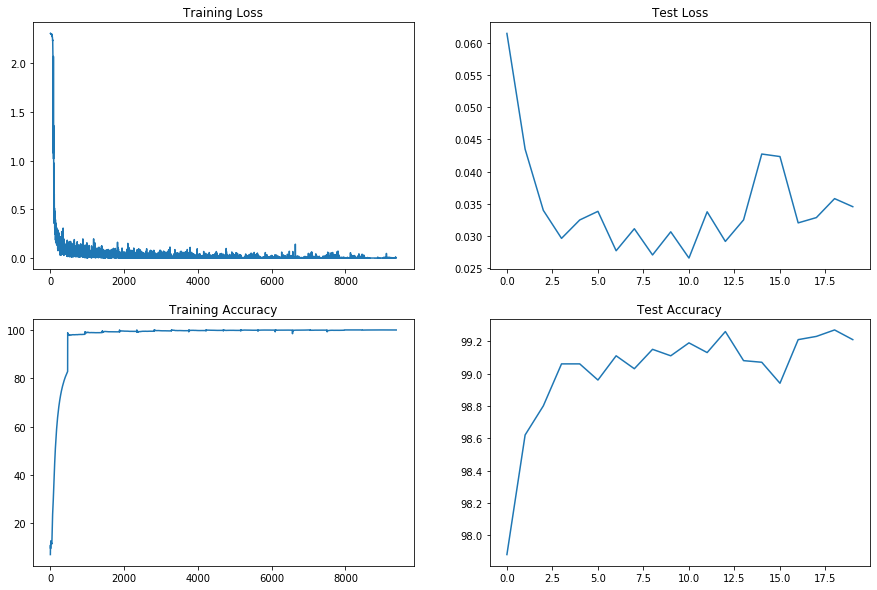

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")